<a href="https://colab.research.google.com/github/AlmondGod/GAN-Engine/blob/main/GAN_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Engine
Hi! Welcome to my NumPy GAN Engine! To use, import your data however you'd prefer, select yoru chosen activation and cost functions in "Generator Instantiation" and "Discriminator Instantiation" (it is recommended to keep ReLU!), and select your Optimizer! Then, adjust the training parameters and simply run the training loop!

###Currently Available:

**Loss Functions:** Quadratic, Binary Cross Entropy

**Activation Functions:** Linear, Sigmoid

**Optional Output Functions:** ReLU, Postlinear, Dropout

**Optimizers:** SGD, Adam


#### Initialize Data

[0. 0. 0. ... 0. 0. 0.]


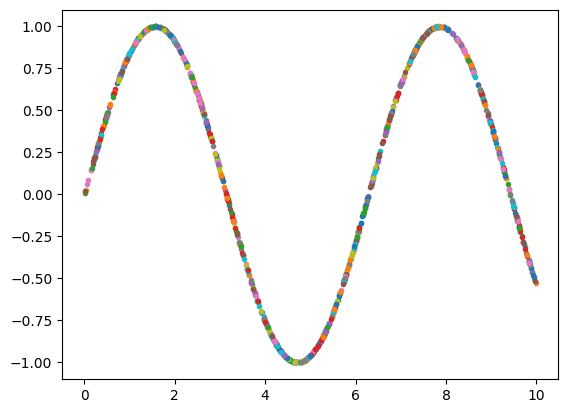

In [ ]:
import numpy as np
import math
import random
import matplotlib
from socket import socket

data_length = 1024

train_input = np.zeros((data_length, 2))

train_labels = np.zeros(data_length)

#train data is tuples of (input, labels)
train_data = np.zeros((data_length, 2, 2))

for i in range(data_length):
  train_input[i][0] = random.random() * 10
  train_input[i][1] = math.sin(train_input[i][0])
  matplotlib.pyplot.plot(train_input[i][0], train_input[i][1], ".")
  train_data[i][0] = train_input[i];
  train_data[i][1] = train_labels[i];

print(train_labels)

#skip tags for now
#input_tags = np.zeros(data_length, 2)

# training_data = [(train_data, input_tags) for i in data_length]

#### Process Data

In [ ]:
batch_size = 32

#loads training data into batches to be iterated on
def train_loader(train_data, batch_size):

  #shuffle data to randomize
  random.shuffle(train_data)

  #data is tensor with batch_size batches, as many as fit in each batch, and
    #train_data dimensions 2,2 for each element
  batch_number = (int) (data_length/batch_size)
  processed_data = np.zeros((batch_number, batch_size, 2, 2))
  current_data_size = 0

  #put data into batches
  for i in range(batch_number):
    for j in range(batch_size):
      processed_data[i][j] = train_data[current_data_size];
      current_data_size += 1

  return processed_data

# stringtest = str(train_loader(train_data, batch_size)[1])
# print(stringtest)

#### Output and Activation Functions

In [ ]:
#ReLU of linear activation
#purpose is to solve vanishing gradients
def ReLU(input):
  return max(0, input)

#input should be same dimension as the layer's weight and bias' 2nd dimension
#weight and bias are the matrices for 1 layer
def LinearActivation(weights, biases, input, relu):
  #instantiate matrix of vector of weighted inputs and vector of outputs
  output_matrices = [[] for _ in range(len(weights))]
  output = np.zeros(len(weights))

  #for each neuron
  for i in range(len(weights)):
    #apply weight and bias to each input
    output_matrices[i] = np.add((np.dot(weights[i], input)), biases[i])
    #sum weighted outputs into scalar output for each neuron
    for j in range(len(output_matrices[i])):
      output[i] += output_matrices[i][j]

    if(relu):
      #apply ReLU to each neuron output
      output[i] = ReLU(output[i])

  return output

#Randomly zeroes some of the elements of the input with probability p
  #When using this, also use Postdropout
#purpose is to prevent coadaptation of neurons (encourage independent neurons)
def Dropout(p, input):
  for i in range(len(input)):
    if (random.random() < p):#if RV = 1 (with probability p)
      input[i] = 0
  return input

#Scale outputs by a factor of 1/(1-p) (this is part of Dropout)
def Postdropout(p, output):
  for i in range(len(output)):
    output[i] = output[i] * (1.0/(1.0-p))
  return output

#applies sigmoid function 1/(1-e^(-x)) to a layer's output
def Sigmoid(output):
  for i in range(len(output)):
    # print(output[i])
    # if(output[i] < -1000):
    #   output[i] = 0.00001
    # elif(output[i] > 700):
    #   output[i] = 0.99999
    # else:
    if (output[i] < 0):
      output[i] = 1 - (1/(1 + math.exp(output[i])))
    else:
      output[i] = 1/(1 + math.exp(-(output[i])))

    #correct
    # if(output[i] == 1):
    #   output[i] = 0.99
    if(output[i] == 0):
      output[i] = 0.001

  return output

def SigmoidPrime(output):
  output = Sigmoid(output)
  multipliers = [None] * len(output)
  for o,_ in enumerate(output):
    multipliers[o] = 1 - output[o]
    output[o] = output[o] * multipliers[o]

  return output

#### Generator Instantiation

In [ ]:
class Generator():
  def __init__(self):
    self.layersizes = [2, 2, 4, 2]
    self.num_layers = len(self.layersizes)

    #get size of largest layer
    largest_layer = 0
    for j in self.layersizes:
      if(largest_layer < j):
        largest_layer = j

    self.total_weights = [[] for _ in range(self.num_layers)]
    self.total_biases = [[] for _ in range(self.num_layers)]

    self.zs = [[] for _ in range(self.num_layers)]
    self.activations = [[] for _ in range(self.num_layers)]

    #use He weight initialization and bias initialization for each layer
    for i in range(0, self.num_layers):
      #number of neurons in this layer
      num_neurons = self.layersizes[i]

      #number of inputs to this layer
      if(i >= 1): num_inputs = self.layersizes[i - 1]
      else: num_inputs = len(train_input[0])

      #this is the matrix of weights and biases for one layer
      self.weights = np.zeros((num_neurons, num_inputs))
      self.biases = np.zeros((num_neurons, num_inputs))

      #for each neuron in the layer
      for j in range(0, num_neurons):
        #initialize this layer of weights + biases (array of neuron arrays)
        weights_layer = np.zeros(num_inputs)
        biases_layer = np.zeros(num_inputs)

        for k in range(0, num_inputs):
          #initialize weight and bias for each neuron to He initialization
          weights_layer[k] = random.normalvariate(0, (2/num_neurons))
          biases_layer[k] = random.normalvariate(0, (2/num_neurons))

        self.weights[j] = weights_layer
        self.biases[j] = biases_layer

      self.total_weights[i] = self.weights
      self.total_biases[i] = self.biases
      # print(self.total_weights[i])
      # print(self.total_biases[i])

  #data is one element in the batch
  def forward(self, input):
    #feed input into first layer
    weights_input = self.total_weights[0]
    biases_input = self.total_biases[0]
    output = LinearActivation(weights_input, biases_input, input, False)
    self.zs[0] = output#store zs (pre-activation function output) for this layer
    # output = Sigmoid(output)
    self.activations[0] = output
    for i in range(1, (self.num_layers - 1)):
      weights_input = self.total_weights[i]
      biases_input = self.total_biases[i]
      output = LinearActivation(weights_input, biases_input, output, False)
      self.zs[i] = output#store zs (pre-activation function output) for this layer
      # output = Sigmoid(output)
      self.activations[i] = output

    #no ReLU on last layer
    weights_input = self.total_weights[self.num_layers - 1]
    biases_input = self.total_biases[self.num_layers - 1]
    output = LinearActivation(weights_input, biases_input, output, False)
    self.zs[self.num_layers - 1] = output#store zs (pre-activation function output) for this layer
    self.activations[self.num_layers - 1] = output

    return output

# generator = Generator()


#### Discriminator Instantiation

In [ ]:
from IPython.core.display import display_png
class Discriminator:
  def __init__(self):
    self.layersizes = [2, 16, 8, 1]
    self.num_layers = len(self.layersizes)

    #get size of largest layer
    largest_layer = 0
    for j in self.layersizes:
      if(largest_layer < j):
        largest_layer = j

    self.total_weights = [[] for _ in range(self.num_layers)]
    self.total_biases = [[] for _ in range(self.num_layers)]

    self.activations = [[] for _ in range(self.num_layers)]
    self.zs = [[] for _ in range(self.num_layers)]

    #use He weight initialization and bias initialization for each layer
    for i in range(0, self.num_layers):
      #number of neurons in this layer
      num_neurons = self.layersizes[i]

      #number of inputs to this layer
      if(i >= 1): num_inputs = self.layersizes[i - 1]
      else: num_inputs = len(train_input[0])

      #this is the matrix of weights and biases for one layer
      self.weights = np.zeros((num_neurons, num_inputs))
      self.biases = np.zeros((num_neurons, num_inputs))

      #for each neuron in the layer
      for j in range(0, num_neurons):
        #initialize this layer of weights + biases (array of neuron arrays)
        weights_layer = np.zeros(num_inputs)
        biases_layer = np.zeros(num_inputs)

        for k in range(0, num_inputs):
          #initialize weight and bias for each neuron to He initialization
          weights_layer[k] = random.normalvariate(0, (2/num_neurons))
          biases_layer[k] = random.normalvariate(0, (2/num_neurons))

        self.weights[j] = weights_layer
        self.biases[j] = biases_layer

      self.total_weights[i] = self.weights
      self.total_biases[i] = self.biases
      # print(self.total_weights[i])
      # print(self.total_biases[i])

      #data is one element in the batch
  #data is one element in the batch
  def forward(self, input):
    #feed input into first layer
    weights_input = self.total_weights[0]
    biases_input = self.total_biases[0]
    output = LinearActivation(weights_input, biases_input, input, False)
    # output = Sigmoid(output)
    self.zs[0] = output#store zs (pre-activation function output) for this layer
    self.activations[0] = output
    for i in range(1, (self.num_layers - 1)):
      weights_input = self.total_weights[i]
      biases_input = self.total_biases[i]
      # output = Dropout(0.3, output) #apply dropout to input
      output = LinearActivation(weights_input, biases_input, output, False)
      self.zs[i] = output#store zs (pre-activation function output) for this layer
      # output = Sigmoid(output)
      # output = Postdropout(0.3, output) #apply postdropout to input
      self.activations[i] = output#store activations for this layer


    #no ReLU or Dropout on last layer, Sigmoid on last layer
    weights_input = self.total_weights[self.num_layers - 1]
    biases_input = self.total_biases[self.num_layers - 1]
    output = LinearActivation(weights_input, biases_input, output, False)
    self.zs[self.num_layers - 1] = output#store zs (pre-activation function output) for this layer
    # print("HELLO")
    # print(self.total_weights)
    # print(output)
    output = Sigmoid(output)
    self.activations[self.num_layers - 1] = output

    return output


# dis = Discriminator()
# print(dis.forward([1, 2]))

#train_loader(train_data, batch_size)[0][0]


#### Loss Functions

In [ ]:
def QuadraticLoss(y_desired, a_output):
  loss = 0

  #sum(y - a)^2
  for y, a in zip(y_desired, a_output):
    loss += (y - a) ** 2

  #/2n
  loss /= (2 * (len(y_desired)))

  return loss

def DerivativeQuadraticLoss(y_desired, a_output):
  lossderivative = [[] for _ in range(len(a_output))];

  for i, (y, a) in enumerate(zip(y_desired, a_output)):
    lossderivative[i] = a - y

  print(f"DerivativeQuadraticLoss y:{y}, a:{a}, loss derivative:{lossderivative}")
  return lossderivative

#given the 1D tensors output layer's output, desired output, and whetehr to do 'sum' or 'mean' return loss
#y_desired and a_output should be between 0 and 1 (this should be true due to sigmoid function)
def BinaryCrossEntropyLoss(y_desired, a_output):
  loss = 0

  for i in range(len(y_desired)):
    loss += (y_desired[i] * (math.log(a_output[i], 10))) + ((1 - y_desired[i]) * (math.log(1 - a_output[i], 10)))

  return loss

def DerivativeBCELoss(y_desired, a_output):
  lossderivative = [[] for _ in range(len(a_output))];
  for i in range(len(y_desired)):

    #if below allowed range, truncate
    # if(a_output[i] <= 1e-324):
    #   a_output[i] = 1e-300

    lossderivative[i] = (y_desired[i] / a_output[i]) + ((1.0 - y_desired[i]) / (1.0 - a_output[i]))
    # print("DBCEL: lossderivs:")
    # print(y_desired[i] / a_output[i])

    # print("DBCEL: 1 - desired")
    # print((1.0 - y_desired[i]))

    # print("DBCEL: output")
    # print(a_output[i])

    # print("DBCEL: 1 - output")
    # print((1.0 - a_output[i]))

  return lossderivative

print(QuadraticLoss(([0.9,0.9]),([0.1,0.002])))
print(DerivativeQuadraticLoss(([0.99,0.99]),([0.01, 0.01])))


print(BinaryCrossEntropyLoss(([0.9,0.9]),([0.1,0.002])))
print(DerivativeBCELoss(([0.99,0.99]),([0.01, 0.01])))


0.36160100000000006
DerivativeQuadraticLoss y:0.99, a:0.01, loss derivative:[-0.98, -0.98]
[-0.98, -0.98]
-3.3337356988297464
[99.01010101010101, 99.01010101010101]


#### Backpropogation for Discriminator

In [ ]:
def Backpropogation(input, network, y_desired, forward = True):
  #forward propogation (unless specified not to)
  if (forward):
    final_output = network.forward(input)
  else: final_output = input #if forward is false, use the input as the output of this network

  #last layer index
  l = network.num_layers - 1
  #matrix to store errors of each neuron
  errors = [[] for _ in range(network.num_layers)]

  d = DerivativeQuadraticLoss(y_desired, final_output)
  s = SigmoidPrime(network.zs[l])

  # print(d)

  last_layer_error = np.multiply(d,s)

  errors[l] = last_layer_error

  #start on second-to-last layer and go backwards through each layer computing errors
  for i in reversed(range(0,network.num_layers - 1)):
    # print(network.total_weights)
    # print (i)
    np.dot(network.total_weights[i + 1].transpose(), errors[i + 1])
    previous_layer_error = np.multiply(np.dot(network.total_weights[i + 1].transpose(), errors[i + 1]), SigmoidPrime(network.zs[i]))
    errors[i] = previous_layer_error

  #get partial derivatives of biases (same as individual neuron error)
  biases_gradient = [[] for _ in range(network.num_layers)]
  for i in range(network.num_layers):
    biases_gradient[i] = errors[i]

  #get partial derivatives of weights
  weights_gradient = [[] for _ in range(network.num_layers)]
  weights_gradient[0] = np.multiply(input, errors[0])

  for i in range(1, network.num_layers):
    weights_gradient[i] = np.multiply(network.activations[i], errors[i])

  return (weights_gradient, biases_gradient)

# discriminator = Discriminator()
# Backpropogation([1,1], generator, [2,2])


#### Backpropogation for Generator

In [ ]:
#compute the weight and bias gradients of the generator using the combined networks as a network
def Generator_Backpropogation(input, generator, discriminator, y_desired):
  #forward propogation (unless specified not to)
  network = generator

  final_output = input #use the input as the output of the discriminator

  #last layer index
  l = network.num_layers - 1
  dl = discriminator.num_layers - 1
  #matrix to store errors of each neuron
  errors = [[] for _ in range(network.num_layers)]
  discriminator_errors = [[] for _ in range(discriminator.num_layers)]

  print(f"y_desired:{y_desired}")
  print(f"final output:{final_output}")

  d = DerivativeQuadraticLoss(y_desired, final_output)
  print(f"d:{d}")
  s = SigmoidPrime(discriminator.zs[dl])
  print(f"zs:{discriminator.zs}")

  print(f"s:{s}")

  last_layer_error = np.multiply(d,s)

  discriminator_errors[dl] = last_layer_error

  #start on second-to-last layer and go backwards through each layer computing errors
  for i in reversed(range(0,network.num_layers + discriminator.num_layers - 1)):
    #discriminator layer index (if it's negative, we're no longer iterating on the discriminator)
    di = i - network.num_layers

    if(i > network.num_layers - 1):
      np.dot(discriminator.total_weights[di + 1].transpose(), discriminator_errors[di + 1])
      previous_layer_error = np.dot(discriminator.total_weights[di + 1].transpose(), discriminator_errors[di + 1])
      discriminator_errors[di] = previous_layer_error

    if(i == network.num_layers - 1):
      np.dot(discriminator.total_weights[di + 1].transpose(), discriminator_errors[di + 1])
      previous_layer_error = np.dot(discriminator.total_weights[di + 1].transpose(), discriminator_errors[di + 1])
      errors[i] = previous_layer_error

    if(i < network.num_layers - 1):
      np.dot(network.total_weights[i + 1].transpose(), errors[i + 1])
      previous_layer_error = np.dot(network.total_weights[i + 1].transpose(), errors[i + 1])
      errors[i] = previous_layer_error

  #get partial derivatives of biases (same as individual neuron error)
  biases_gradient = [[] for _ in range(network.num_layers)]
  for i in range(network.num_layers):
    biases_gradient[i] = errors[i]

  #get partial derivatives of weights
  weights_gradient = [[] for _ in range(network.num_layers)]
  weights_gradient[0] = np.multiply(input, errors[0])

  for i in range(1, network.num_layers):
    weights_gradient[i] = np.multiply(network.activations[i], errors[i])

  return (weights_gradient, biases_gradient)

discriminat = Discriminator()
generat = Generator()

disoutput = discriminat.forward(generat.forward([0.4, 0.2]))
print(disoutput)
Generator_Backpropogation(disoutput, generat, discriminat, [0])


[0.001]
y_desired:[0]
final output:[0.001]
DerivativeQuadraticLoss y:0, a:0.001, loss derivative:[0.001]
d:[0.001]
zs:[array([ -3.58501933, -10.11986646]), array([-0.22096036,  1.25836108,  3.16735528,  3.01627957,  1.22268555,
        2.26283181,  0.45609474, -0.73579549,  5.36077841, -2.26375267,
        3.63623117, -4.46535899, -2.17567574,  4.57106479, -2.55368204,
        1.69613052]), array([-62.06775405, -44.86082781, -19.76537355,  40.40258295,
       -69.87674233,  36.46461163,  14.19258898, -45.26197215]), array([0.24999994])]
s:[0.24999994]


([array([1.82126683e-06, 4.22035302e-06]),
  array([-4.41196905e-05,  5.27599582e-05]),
  array([ 4.48744431e-05, -7.48950143e-05,  1.62985156e-05, -1.01815963e-05]),
  array([-0.00019396,  0.00010234])],
 [array([7.28506914e-06, 1.68814163e-05]),
  array([-8.11639505e-06, -1.96553773e-05]),
  array([-1.74431755e-05,  3.56059777e-05, -2.00594438e-05, -3.75606128e-06]),
  array([2.61368406e-05, 5.49418937e-06])])

#### Optimizers

In [ ]:
from IPython.core import inputtransformer2
class StochasticGradientDescentOptimizer():
  def __init__(self, lr = 0.1):
    self.learning_rate = lr

  def update(self, inputs, network, y_desireds, forward = True, sigmoid = False):
    for i in range(len(inputs)):
      #get weights and biases gradients through forward and backpropogation
      (weights_gradient, biases_gradient) = Backpropogation(inputs[i], network, y_desireds[i], forward)
      # print(inputs[i])
      # print(y_desireds[i])
      # print(weights_gradient)
      for l in (range(network.num_layers)):
        for n in range(len(network.total_weights[l])):
          for w in range(len(network.total_weights[l][n])):
            network.total_weights[l][n][w] = network.total_weights[l][n][w] - ((self.learning_rate / len(inputs)) * weights_gradient[l][n])
            network.total_biases[l][n][w] = network.total_biases[l][n][w] - ((self.learning_rate / len(inputs)) * biases_gradient[l][n])
      # print(network.activations[network.num_layers - 1])
      # print(network.total_weights[1][1][1])


  def update_generator(self, inputs, generator, discriminator, y_desireds):
    network = generator
    for i in range(len(inputs)):
      #get weights and biases gradients through forward and backpropogation
      (weights_gradient, biases_gradient) = Generator_Backpropogation(inputs[i], network, discriminator, y_desireds[i])
      # print(inputs[i])
      # print(y_desireds[i])
      # print(weights_gradient)
      for l in (range(network.num_layers)):
        for n in range(len(network.total_weights[l])):
          for w in range(len(network.total_weights[l][n])):
            network.total_weights[l][n][w] = network.total_weights[l][n][w] - ((self.learning_rate / len(inputs)) * weights_gradient[l][n])
            network.total_biases[l][n][w] = network.total_biases[l][n][w] - ((self.learning_rate / len(inputs)) * biases_gradient[l][n])

      # print(network.activations[network.num_layers - 1])
      # print(network.total_weights[1][1][1])

SGDO = StochasticGradientDescentOptimizer()
SGDO.update([[1,1], [2,3], [4, 5], [6,7]], discriminat, [[1], [2], [2], [3]])
SGDO.update_generator([[1], [2], [4], [6]], generat, discriminat, [[1], [2], [2], [3]])

DerivativeQuadraticLoss y:1, a:0.001, loss derivative:[-0.999]
DerivativeQuadraticLoss y:2, a:0.9680224864570403, loss derivative:[-1.0319775135429596]
DerivativeQuadraticLoss y:2, a:1.0, loss derivative:[-1.0]
DerivativeQuadraticLoss y:3, a:1.0, loss derivative:[-2.0]
y_desired:[1]
final output:[1]
DerivativeQuadraticLoss y:1, a:1, loss derivative:[0]
d:[0]
zs:[array([5.56726469e-04, 3.44263091e-06]), array([0.16934262, 0.2221489 , 0.01815849, 0.0164972 , 0.06081203,
       0.02719319, 0.24862428, 0.20693313, 0.00190104, 0.00843692,
       0.01004043, 0.00580566, 0.06298382, 0.00251811, 0.06025545,
       0.14090526]), array([0.00000000e+00, 0.00000000e+00, 3.02252973e-05, 9.99000000e-04,
       0.00000000e+00, 2.22044605e-16, 3.99501493e-04, 0.00000000e+00]), array([0.24759947])]
s:[0.24759947]
y_desired:[2]
final output:[2]
DerivativeQuadraticLoss y:2, a:2, loss derivative:[0]
d:[0]
zs:[array([5.56726469e-04, 3.44263091e-06]), array([0.16934262, 0.2221489 , 0.01815849, 0.0164972 , 0

#### Optimizers II

In [ ]:
#Implementation of Adam optimization
class AdamOptimizer():
  def __init__(self, lr = 0.1, b1 = 0.9, b2 = 0.999, e = 1e-08):
    self.learning_rate = lr
    self.beta1 = b1
    self.beta2 = b2
    self.epsilon = e
    self.t_iterations = 0
    self.old_m = None
    self.old_v = None
    self.m_w = None
    self.v_w = None
    self.m_b = None
    self.v_b = None

  def update(self, input, network, y_desired, n_iter):
    #forwardpropogation
    output = network.forward(input)

    #backpropogation
    weights_gradient, biases_gradient = Backpropogation(input, network, y_desired)

    self.m = [np.zeros_like(weight_grad) for weight_grad in weights_gradient]
    self.v = [np.zeros_like(weight_grad) for weight_grad in weights_gradient]
    #compute gradient

    weights_gradient, biases_gradient = Backpropogation(input, network, y_desired)

    #calculate first and second moments
    for t in (range(n_iter)):
      self.ms[self.t] = (self.beta1) * self.ms[self.t - 1] + (1 - self.beta1)*weights_gradient
      self.vs[self.t] = (self.beta1) * self.vs[self.t - 1] + (1 - self.beta1)*weights_gradient

    #calculate step size and direction

    #adjust weights and biases
    network.total_biases -= network.total_biases - (learning_rate * self.ms)
    network.total_weights -= network.total_weights - (learning_rate * self.ms)

#### Training Setup

In [ ]:
learning_rate = 0.05
num_epochs = 2

#### Training

In [ ]:
discriminator = Discriminator()
generator = Generator()
SGD = StochasticGradientDescentOptimizer(learning_rate)

right = 0
wrong = 0
for w in range(1000):
  if((SGD.learning_rate > 0.1)):
     SGD.learning_rate -= 0.0001
  print(f"learning rate: {SGD.learning_rate}")

  for o, i in enumerate(train_input):
    if(o % 100 == 0):
      right = 0
      wrong = 0
      print("reset!-------------------------------------")

    # print (f"Number: {o}")
    # want the discriminator to output 1 for all real data
    real_labels = np.ones((1, 1))
    #and 0 for all generated data
    generated_labels = np.zeros((1, 1))

    #input to generator to get generate output (discriminator input)
    latent_space = np.random.rand(1, 2)

    #we want generated data which we get from the generator
    generated = [[] for _ in range(len(latent_space))]
    for x, sample in enumerate(latent_space):
      # print(sample)
      generated[x] = generator.forward(sample)

    all_samples = np.concatenate(([i], generated))
    all_sample_labels = np.concatenate((real_labels, generated_labels))

    SGD.update(all_samples, discriminator, all_sample_labels, sigmoid = True)

    if(discriminator.forward(i) >= 0.95):
      right += 1
      print(f"real output: {discriminator.forward(i)}")
    else: wrong += 1

    if(discriminator.forward(generated[0]) <= 0.05):
      right += 1
      print(f"false output: {generated[0]}, {discriminator.forward(generated[0])}")
    else: wrong += 1

    # print(f"generated: {generated[0]}")
    print(f"accuracy: {right/(right + wrong)}")

    print(f"discriminator weight: {discriminator.total_weights[2][0]}")
    #####################################
    #input to generator for training
    latent_space = np.random.rand(1, 2)

    #the output of the generator is the discriminators output, which should be 1.
    #store output of generator in generated_samples
    generated_samples = [[] for _ in latent_space]
    for i, input in enumerate(latent_space):
      generated_samples[i] = generator.forward(input)

    #store output of discriminator from generated input in output_discriminator_generated
    output_discriminator_generated = [[] for I in generated_samples]
    for i, input in enumerate(generated_samples):
      output_discriminator_generated[i] = discriminator.forward(input)

    #compute gradients of generator using output of discriminator and update using SGD
    #Specifies no forwardprop in the function itself
    SGD.update_generator(output_discriminator_generated, generator, discriminator, real_labels)

  print(discriminator.forward(train_input[4]))
  print(discriminator.forward(train_input[200]))
  print(discriminator.forward(train_input[134]))
  print(discriminator.forward(train_input[800]))
  print(discriminator.forward(train_input[20]))
  print(discriminator.forward(train_input[520]))
  print(discriminator.forward([-5, 4]))
  print(discriminator.forward([-25, -10]))
  print(discriminator.forward([13, -10]))
  # print()


In [ ]:
rlatent_space = np.random.rand(1, 2)
#we want generated data which we get from the generator

rgenerated = [[] for _ in range(len(rlatent_space))]
for x, sample in enumerate(rlatent_space):
  rgenerated[x] = generator.forward(sample)
  print(rgenerated[x])

print(discriminator.forward([-5, 4]))
print(discriminator.forward([-5, -10]))
print(discriminator.forward([-13, 12]))

In [ ]:
discriminator = Discriminator()
generator = Generator()
SGD = StochasticGradientDescentOptimizer()

for epoch in range(num_epochs):#for each epoch
  for n, batch in enumerate(train_loader(train_data, batch_size)):#for each batch in the epoch
    print(n)
    print("-----------------------------------------------")
    #want the discriminator to output 1 for all real data
    real_labels = np.ones((batch_size, 1))
    #and 0 for all generated data
    generated_labels = np.zeros((batch_size, 1))

    #input to generator to get generate output (discriminator input)
    latent_space = np.random.rand(batch_size, 2)

    #we want generated data which we get from the generator
    generated = [[] for _ in range(len(latent_space))]
    for i, sample in enumerate(latent_space):
      # print(sample)
      generated[i] = generator.forward(sample)

    print(generated[1])

    #isolate batch_input
    batch_input = [[] for _ in range(len(batch))]
    for i, item in enumerate(batch):
      batch_input[i] = item[0]

    # print(batch_input)
    #we want to input both real and generated samples into the discriminator
    all_samples = np.concatenate((batch_input, generated))
    all_sample_labels = np.concatenate((real_labels, generated_labels))

    #shuffle data but keep it corresponding
    # assert len(all_samples) == len(all_sample_labels)
    # p = np.random.permutation(len(all_samples))
    # all_samples = all_samples[p]
    # all_sample_labels = all_sample_labels[p]

    # print(f"generated: {generated}")

    # print("one")
    #train the discriminator
    SGD.update(all_samples, discriminator, all_sample_labels)
    # print("two")

    #input to generator for training
    latent_space = np.random.rand(batch_size, 2)

    #the output of the generator is the discriminators output, which should be 1.
    #store output of generator in generated_samples
    generated_samples = [[] for _ in latent_space]
    for i, input in enumerate(latent_space):
      generated_samples[i] = generator.forward(input)

    #store output of discriminator from generated input in output_discriminator_generated
    output_discriminator_generated = [[] for I in generated_samples]
    for i, input in enumerate(generated_samples):
      output_discriminator_generated[i] = discriminator.forward(input)

    #compute gradients of generator using output of discriminator and update using SGD
      #Specifies no forwardprop in the function itself
    SGD.update(output_discriminator_generated, generator, real_labels, forward = False)

    if epoch % 10 == 0 and n == batch_size - 1:
      print(f"Epoch: {epoch}   Loss D: {discriminator.activations[discriminator.num_layers - 1]}")
      print(f"Epoch: {epoch}   Loss G: {generator.activations[generator.num_layers - 1]}")



In [ ]:
lssamples = np.random.rand(100,2)

generatedsamples = [[] for _ in lssamples]

for i, l in enumerate(lssamples):
  generatedsamples[i] = generator.forward(l)
  matplotlib.pyplot.plot(generatedsamples[i][0], generatedsamples[i][1],".")